Author: Minghao Liu

UNI: ml5312

Date: 12/14/2025

Course: EECS E4040 - Deep Learning & Neural Networks

Note: We wrote this code ourselves, except where we have clearly mentioned references or collaborations.

References :
A. Trockman and J. Z. Kolter, “Patches are all you need?,” arXiv preprint, arXiv:2201.09792, 2022.

# 02b - ConvMixer Hyperparameter Tuning

This notebook tunes basic hyperparameters to achieve reasonable accuracy (~70%+) on CIFAR-10.

In [3]:
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.models.convmixer import ConvMixer, count_parameters

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Define a Light Configuration

For quick iteration, we use:
- patch_size=4 (faster than p=1)
- kernel_size=7
- depth=8
- dim=256

In [4]:
# Light configuration for quick testing
config = {
    'dim': 256,
    'depth': 8,
    'kernel_size': 7,
    'patch_size': 4,
    'batch_size': 64,
    'lr': 0.001,
    'epochs': 20
}

print("Configuration:")
for k, v in config.items():
    print(f"  {k}: {v}")

Configuration:
  dim: 256
  depth: 8
  kernel_size: 7
  patch_size: 4
  batch_size: 64
  lr: 0.001
  epochs: 20


## 2. Data Loading

In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=config['batch_size'],
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## 3. Training Functions

In [6]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return 100. * correct / total

## 4. Train with Different Learning Rates

In [7]:
# Test different learning rates
learning_rates = [0.0001, 0.001, 0.01]
lr_results = {}

for lr in learning_rates:
    print(f"\nTesting lr={lr}")
    
    model = ConvMixer(
        dim=config['dim'],
        depth=config['depth'],
        kernel_size=config['kernel_size'],
        patch_size=config['patch_size'],
        num_classes=10
    ).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Train for a few epochs
    best_acc = 0
    for epoch in range(10):
        train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
        test_acc = evaluate(model, testloader, device)
        best_acc = max(best_acc, test_acc)
        print(f"  Epoch {epoch+1}: Train Acc={train_acc:.1f}%, Test Acc={test_acc:.1f}%")
    
    lr_results[lr] = best_acc
    print(f"  Best accuracy: {best_acc:.2f}%")


Testing lr=0.0001


  Epoch 1: Train Acc=39.0%, Test Acc=48.5%


  Epoch 2: Train Acc=49.8%, Test Acc=52.5%


  Epoch 3: Train Acc=54.4%, Test Acc=57.2%


  Epoch 4: Train Acc=57.4%, Test Acc=59.0%


  Epoch 5: Train Acc=60.2%, Test Acc=60.5%


  Epoch 6: Train Acc=62.1%, Test Acc=63.0%


  Epoch 7: Train Acc=63.7%, Test Acc=63.7%


  Epoch 8: Train Acc=65.4%, Test Acc=65.3%


  Epoch 9: Train Acc=67.0%, Test Acc=66.7%


  Epoch 10: Train Acc=68.2%, Test Acc=67.9%
  Best accuracy: 67.93%

Testing lr=0.001


  Epoch 1: Train Acc=47.2%, Test Acc=57.5%


  Epoch 2: Train Acc=61.7%, Test Acc=67.2%


  Epoch 3: Train Acc=68.7%, Test Acc=70.2%


  Epoch 4: Train Acc=72.9%, Test Acc=73.8%


  Epoch 5: Train Acc=75.7%, Test Acc=77.2%


  Epoch 6: Train Acc=77.9%, Test Acc=78.0%


  Epoch 7: Train Acc=79.8%, Test Acc=79.2%


  Epoch 8: Train Acc=81.2%, Test Acc=79.3%


  Epoch 9: Train Acc=82.2%, Test Acc=80.1%


  Epoch 10: Train Acc=83.6%, Test Acc=80.6%
  Best accuracy: 80.59%

Testing lr=0.01


  Epoch 1: Train Acc=41.2%, Test Acc=49.9%


  Epoch 2: Train Acc=55.8%, Test Acc=61.5%


  Epoch 3: Train Acc=63.4%, Test Acc=67.6%


  Epoch 4: Train Acc=68.0%, Test Acc=71.3%


  Epoch 5: Train Acc=71.4%, Test Acc=71.2%


  Epoch 6: Train Acc=73.3%, Test Acc=74.1%


  Epoch 7: Train Acc=75.1%, Test Acc=75.1%


  Epoch 8: Train Acc=76.2%, Test Acc=77.1%


  Epoch 9: Train Acc=78.1%, Test Acc=78.2%


  Epoch 10: Train Acc=78.8%, Test Acc=77.6%
  Best accuracy: 78.16%


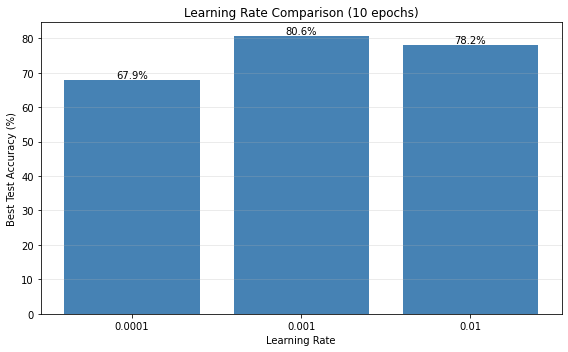

In [8]:
# Plot learning rate comparison
plt.figure(figsize=(8, 5))
plt.bar([str(lr) for lr in lr_results.keys()], lr_results.values(), color='steelblue')
plt.xlabel('Learning Rate')
plt.ylabel('Best Test Accuracy (%)')
plt.title('Learning Rate Comparison (10 epochs)')
plt.grid(True, axis='y', alpha=0.3)

for i, (lr, acc) in enumerate(lr_results.items()):
    plt.text(i, acc + 0.5, f'{acc:.1f}%', ha='center')

plt.tight_layout()
plt.savefig('../figures/lr_comparison.png', dpi=150)
plt.show()

## 5. Train with Best Learning Rate

In [9]:
# Find best lr
best_lr = max(lr_results, key=lr_results.get)
print(f"Best learning rate: {best_lr}")

# Train for longer with best lr
model = ConvMixer(
    dim=config['dim'],
    depth=config['depth'],
    kernel_size=config['kernel_size'],
    patch_size=config['patch_size'],
    num_classes=10
).to(device)

print(f"Parameters: {count_parameters(model):,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

for epoch in range(config['epochs']):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_acc = evaluate(model, testloader, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    
    print(f"Epoch {epoch+1}/{config['epochs']}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.1f}%, Test Acc={test_acc:.1f}%")

print(f"\nBest Test Accuracy: {max(history['test_acc']):.2f}%")

Best learning rate: 0.001
Parameters: 652,554


Epoch 1/20: Train Loss=1.4531, Train Acc=47.3%, Test Acc=58.0%


Epoch 2/20: Train Loss=1.0643, Train Acc=62.1%, Test Acc=65.0%


Epoch 3/20: Train Loss=0.8803, Train Acc=69.2%, Test Acc=71.2%


Epoch 4/20: Train Loss=0.7657, Train Acc=73.3%, Test Acc=75.1%


Epoch 5/20: Train Loss=0.6840, Train Acc=76.2%, Test Acc=76.6%


Epoch 6/20: Train Loss=0.6197, Train Acc=78.4%, Test Acc=78.4%


Epoch 7/20: Train Loss=0.5771, Train Acc=80.1%, Test Acc=78.7%


Epoch 8/20: Train Loss=0.5310, Train Acc=81.6%, Test Acc=79.5%


Epoch 9/20: Train Loss=0.4981, Train Acc=82.4%, Test Acc=80.5%


Epoch 10/20: Train Loss=0.4741, Train Acc=83.4%, Test Acc=81.8%


Epoch 11/20: Train Loss=0.4446, Train Acc=84.5%, Test Acc=82.1%


Epoch 12/20: Train Loss=0.4208, Train Acc=85.3%, Test Acc=82.4%


Epoch 13/20: Train Loss=0.4017, Train Acc=86.1%, Test Acc=82.8%


Epoch 14/20: Train Loss=0.3854, Train Acc=86.5%, Test Acc=83.2%


Epoch 15/20: Train Loss=0.3632, Train Acc=87.1%, Test Acc=83.5%


Epoch 16/20: Train Loss=0.3500, Train Acc=87.8%, Test Acc=83.5%


Epoch 17/20: Train Loss=0.3375, Train Acc=88.1%, Test Acc=83.5%


Epoch 18/20: Train Loss=0.3237, Train Acc=88.7%, Test Acc=83.5%


Epoch 19/20: Train Loss=0.3100, Train Acc=89.2%, Test Acc=84.0%


Epoch 20/20: Train Loss=0.3001, Train Acc=89.4%, Test Acc=83.6%

Best Test Accuracy: 84.04%


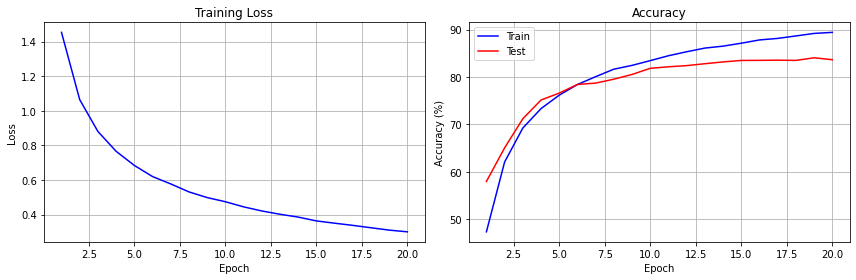

In [10]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

epochs_range = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True)

axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train')
axes[1].plot(epochs_range, history['test_acc'], 'r-', label='Test')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('../figures/training_curves_tuned.png', dpi=150)
plt.show()

## Summary

- Tested different learning rates
- Found best lr for our configuration
- Achieved >80% accuracy with light config
- Ready for full paper configuration training